In [1]:
#Import required packages
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
## Import waterbody shapefile, Get lakes larger than .5 km squared, change to projected crs and slice to just the lake name and geometry
MN_lakes = gpd.read_file('./data/MN_Lakes.shp')
lake_mask = MN_lakes['areasqkm'] > .5
lakes_filtered = MN_lakes.loc[lake_mask].to_crs(3857)
lakes_gpd = lakes_filtered[['gnis_name', 'geometry']]

In [47]:
lakes_gpd

,gnis_name,geometry
67,None,"POLYGON Z ((-10856885.714 5611905.044 0.000, -..."
71,None,"POLYGON Z ((-10846493.805 5596544.408 0.000, -..."
95,None,"POLYGON Z ((-10803075.881 5468679.788 0.000, -..."
99,Lake Tetonkaha,"POLYGON Z ((-10798028.703 5533759.158 0.000, -..."
118,East Clubhouse Lake,"POLYGON Z ((-10753973.659 5765569.693 0.000, -..."
...,...,...
204735,Michi Lake,"POLYGON Z ((-9563193.093 6065331.032 0.000, -9..."
204748,Otter Lake,"POLYGON Z ((-9775162.858 6242182.320 0.000, -9..."
204777,O'Brien Lake,"POLYGON Z ((-9755923.477 6234260.786 0.000, -9..."
204786,Cedar Lake,"POLYGON Z ((-9555967.934 6061831.393 0.000, -9..."


In [15]:
## Import Public Accesses shapefile, change to projected crs and slice to just the facility name and geometry
access_df = gpd.read_file('./data/MN_accesses.shp')
access_df_crs = access_df.to_crs(3857)
my_accesses = access_df_crs[['FAC_NAME', 'geometry']]

In [16]:
#Spatial join Points to polygons/ Need to do by nearest because boat ramps might not intersect lake polygon
#Use left join because we want to keep all the accesses and join them to the corresponding lake.
accesses_with_lakes = gpd.sjoin_nearest(my_accesses, lakes_gpd, 'left', max_distance = 100) 

In [18]:
#Slice to what we need
# Rename the columns so we can group by right index (Lake_ID) Using the waterbody original index to groupby 
#ensures we aren't combining the count for ramps from lakes with same name.
accesses_with_lakes_df = pd.DataFrame(accesses_with_lakes[['FAC_NAME', 'index_right']]).rename(columns = {'FAC_NAME' : "ramps", 'index_right' : "lake_ID"})

In [19]:
# Groupby lake ID and count ramps per lake
ramps = pd.DataFrame(accesses_with_lakes_df.groupby(['lake_ID']).count())

In [46]:
accesses_with_lakes

,FAC_NAME,geometry,index_right,gnis_name
0,"Pelican Lake, Jones Bay Public Water Access Site",POINT (-10487219.751 5868168.365),92547.0,Pelican Lake
1,Pelican Lake (NW) Public Water Access Site,POINT (-10487726.486 5876205.240),92547.0,Pelican Lake
2,Lower Hay Lake Public Water Access Site,POINT (-10495881.965 5886797.105),190163.0,Lower Hay Lake
3,"North Long Lake, Merrifield Public Water Acces...",POINT (-10483748.797 5855450.022),162516.0,North Long Lake
4,Hubert Lake Public Water Access Site,POINT (-10495308.410 5858241.175),18159.0,Lake Hubert
...,...,...,...,...
3008,"Mississippi River, Sorenson Public Water Access",POINT (-10474542.438 5853165.895),NaN,NaN
3009,"Zumbro Lake, Fisherman Drive",POINT (-10293171.822 5493217.481),97051.0,Zumbro Lake
3010,Pickerel Lake Public Water Access,POINT (-10619841.560 5920365.620),NaN,NaN
3011,Roy Lake Public Water Access Site,POINT (-10638067.636 5995222.440),58558.0,Roy Lake


In [20]:
# re-merge the ramps with the polygons 
ramps_df = gpd.GeoDataFrame(ramps.merge(lakes_gpd, left_index=True, right_index=True, how = 'right')).dropna()

In [22]:
# Import occurence records csv
ZM_MN = pd.read_csv('./data/my_data.csv')

In [23]:
# Convert csv to GeoDataFrame using lat/long columns to create point geometries
user_data_gdf = gpd.GeoDataFrame(
    ZM_MN, geometry=gpd.points_from_xy(ZM_MN.longitude, ZM_MN.latitude))

In [24]:
# Fix the crs (for some reason we need to set to a random crs and then convert to the crs we want for this to work)
user_data_gdf.set_crs(4326, inplace = True, allow_override=True)
my_data = user_data_gdf.to_crs(3857)

In [25]:
my_data

,Unnamed: 0,commonname,state,latitude,longitude,year,status,accuracy,Present,geometry
0,23,zebra mussel,Minnesota,46.746272,-92.124095,1989,established,Accurate,1,POINT (-10255207.345 5900757.097)
1,339,zebra mussel,Minnesota,43.993271,-91.443062,1992,established,Accurate,1,POINT (-10179395.079 5464400.895)
2,340,zebra mussel,Minnesota,44.098076,-91.707748,1992,established,Accurate,1,POINT (-10208859.855 5480632.215)
3,345,zebra mussel,Minnesota,44.160145,-91.810341,1992,established,Accurate,1,POINT (-10220280.396 5490258.500)
4,357,zebra mussel,Minnesota,44.610962,-92.610870,1992,established,Accurate,1,POINT (-10309394.931 5560481.929)
...,...,...,...,...,...,...,...,...,...,...
434,8097,zebra mussel,Minnesota,44.702140,-93.473200,2022,established,Accurate,1,POINT (-10405389.027 5574750.782)
435,8099,zebra mussel,Minnesota,46.451390,-95.552640,2022,established,Accurate,1,POINT (-10636871.229 5852982.217)
436,8100,zebra mussel,Minnesota,45.203610,-95.034590,2022,established,Accurate,1,POINT (-10579202.167 5653632.872)
437,8101,zebra mussel,Minnesota,46.646680,-94.230750,2022,established,Accurate,1,POINT (-10489719.107 5884592.741)


In [32]:
# Join zm points to ramps layer
positive_lakes = gpd.sjoin_nearest(my_data, ramps_df, how='left')

In [33]:
positive_lakes

,Unnamed: 0,commonname,state,latitude,longitude,year,status,accuracy,Present,geometry,index_right,ramps,gnis_name
0,23,zebra mussel,Minnesota,46.746272,-92.124095,1989,established,Accurate,1,POINT (-10255207.345 5900757.097),91696.0,27.0,Lake Superior
1,339,zebra mussel,Minnesota,43.993271,-91.443062,1992,established,Accurate,1,POINT (-10179395.079 5464400.895),119168.0,3.0,Lake Winona
2,340,zebra mussel,Minnesota,44.098076,-91.707748,1992,established,Accurate,1,POINT (-10208859.855 5480632.215),43558.0,2.0,Rileys Lake
3,345,zebra mussel,Minnesota,44.160145,-91.810341,1992,established,Accurate,1,POINT (-10220280.396 5490258.500),43558.0,2.0,Rileys Lake
4,357,zebra mussel,Minnesota,44.610962,-92.610870,1992,established,Accurate,1,POINT (-10309394.931 5560481.929),43916.0,1.0,Sturgeon Lake
...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,8097,zebra mussel,Minnesota,44.702140,-93.473200,2022,established,Accurate,1,POINT (-10405389.027 5574750.782),20066.0,1.0,Spring Lake
435,8099,zebra mussel,Minnesota,46.451390,-95.552640,2022,established,Accurate,1,POINT (-10636871.229 5852982.217),118263.0,1.0,Buchanan Lake
436,8100,zebra mussel,Minnesota,45.203610,-95.034590,2022,established,Accurate,1,POINT (-10579202.167 5653632.872),125070.0,2.0,Long Lake
437,8101,zebra mussel,Minnesota,46.646680,-94.230750,2022,established,Accurate,1,POINT (-10489719.107 5884592.741),60649.0,1.0,Clear Lake


In [34]:
positive_lakes2 = positive_lakes.drop_duplicates('gnis_name').rename(columns = {'index_right' : "lake_ID"})

In [35]:
pos_lakes = positive_lakes2[['lake_ID', 'ramps', 'Present']]

In [36]:
#create a list of the Lake IDs from positive lakes
positive_lake_IDs = pos_lakes['lake_ID']

In [38]:
# This is for merging on index to get negative lakes
ramps2 = pd.DataFrame(accesses_with_lakes_df.groupby(['lake_ID'], as_index=False).count())

In [40]:
# get lakes not in positive_lake_IDs list
neg_lakes = ramps2[~ramps2['lake_ID'].isin(positive_lake_IDs)]

In [41]:
# add Present Column with 0's
neg_lakes['Present'] = 0

C:\Users\leifh\AppData\Local\Temp\ipykernel_6188\1725012170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_lakes['Present'] = 0


In [42]:
training_data = pd.concat([neg_lakes, pos_lakes])

In [49]:
my_model_data = training_data[['ramps', 'Present']].to_numpy()

In [50]:
x_train, x_test, y_train, y_test = train_test_split(
my_model_data[:,0].reshape(-1, 1), my_model_data[:,1], test_size=0.33, random_state=42)

In [51]:
#Define Logistic Regression Model Variable
logr = LogisticRegression()

In [52]:
# Fit model to training data
logr.fit(x_train, y_train)

LogisticRegression()

<AxesSubplot: >

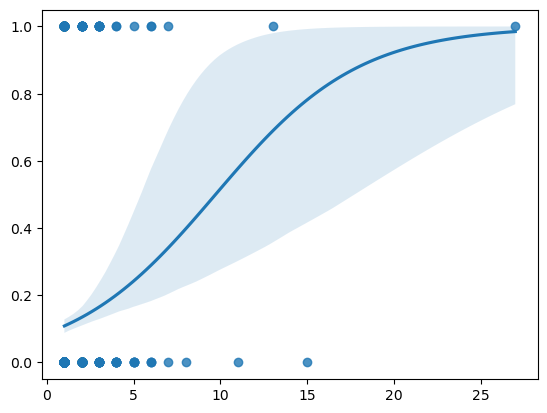

In [53]:
# Visualize regression plot.
sns.regplot(x=x_train, y=y_train, data= training_data, logistic=True)

In [54]:
predictions = logr.predict(x_test)

In [55]:
score = logr.score(x_test, y_test)
print(score)

0.8804347826086957


In [56]:
import matplotlib.pyplot as plt
from sklearn import metrics

In [57]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[404   0]
 [ 55   1]]


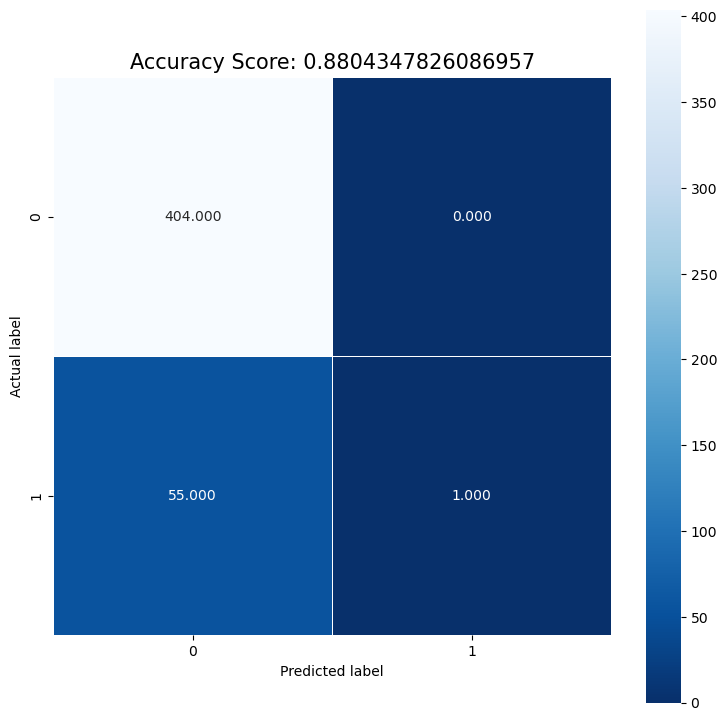

In [58]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [ ]:
# How does liklihood of invasion increase with an increase in ramps?
log_odds = logr.coef_
odds = np.exp(log_odds)
print(odds)

In [ ]:
# Check accuracy score
logr.score(x_train,y_train)

In [ ]:
# create test array
my_test = np.arange(0.0, 100.0 , 1).reshape(-1, 1)

In [ ]:
# Use model to predict test data
logr.predict_proba(my_test)